<span style="font-size:50px"><strong>ML4HC Project 1 - Task 3</strong></span>


In [40]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score


# Define paths
data_dir = "../ml4h_data/p1/"#"data"

pd.set_option('display.max_columns', None)


# Transformer Model - Q2.3

### Model and training loop

In [84]:
class Transformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2, num_classes=1, max_len=49,dropout=0.1):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, model_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_head = nn.Sequential(
            nn.Linear(model_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (B, T, F)
        x = self.input_proj(x)                     # -> (B, T, D)
        x = x + self.positional_encoding[:, :x.size(1)]  # add position info
        x = self.transformer(x)                    # -> (B, T, D)
        x = x.mean(dim=1)                          # average pooling
        return self.cls_head(x).squeeze(-1)


In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score

def train_transformer(model, dataloader, val_dataloader=None, epochs=10, lr=1e-3, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    history = {"train_loss": [], "val_loss": [], "val_auroc": [], "val_auprc": []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(x_batch).squeeze()
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        history["train_loss"].append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f}")

        if val_dataloader:
            auroc, auprc, val_loss = evaluate_transformer(model, val_dataloader, device)
            history["val_loss"].append(val_loss)
            history["val_auroc"].append(auroc)
            history["val_auprc"].append(auprc)

    # Plot after training
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history["train_loss"], label="Train Loss")
    if history["val_loss"]:
        plt.plot(epochs_range, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history["val_auroc"], label="AUROC")
    plt.xlabel("Epoch"); plt.ylabel("AUROC"); plt.title("Validation AUROC")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history["val_auprc"], label="AUPRC")
    plt.xlabel("Epoch"); plt.ylabel("AUPRC"); plt.title("Validation AUPRC")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return history


def evaluate_transformer(model, dataloader, device):
    model.eval()
    all_probs, all_labels = [], []
    total_loss = 0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch).squeeze()
            loss = criterion(logits, y_batch)
            total_loss += loss.item()
            probs = torch.sigmoid(logits).cpu()
            all_probs.append(probs)
            all_labels.append(y_batch.cpu())

    probs = torch.cat(all_probs)
    labels = torch.cat(all_labels)

    auroc = roc_auc_score(labels, probs)
    auprc = average_precision_score(labels, probs)
    val_loss = total_loss / len(dataloader)

    print(f"Val AUROC: {auroc:.4f}  AUPRC: {auprc:.4f}  Val Loss: {val_loss:.4f}")
    return auroc, auprc, val_loss


In [78]:
def get_data(split="train"):
    letter_map = {"train": "a", "val": "b", "test": "c"}
    letter = letter_map[split]
    df = pd.read_parquet(f"data_{letter}_scaled.parquet")

    df = df.sort_values(by=["RecordID", "Time"])

    # Move RecordID and Time to the front
    cols = ["RecordID", "Time"] + [col for col in df.columns if col not in ["RecordID", "Time"]]
    df = df[cols]

    # Remove label from features
    features = [col for col in df.columns if col not in ["RecordID", "Time", "In-hospital_death"]]

    # Group time series per patient
    grouped = df.groupby("RecordID")[features].apply(lambda x: x.to_numpy()).tolist()
    assert all(x.shape == (49, 40) for x in grouped), "Not all patients have shape (49, 41)"

    # Convert to tensor
    X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in grouped])  # (N, 49, 41)

    # Extract labels
    y = torch.tensor(df.groupby("RecordID")["In-hospital_death"].first().values, dtype=torch.float32)

    dataset = TensorDataset(X, y) 
    return dataset


### Testing

In [85]:
train_dataset = get_data("train")
val_dataset = get_data("val")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

model = Transformer(input_dim=40, model_dim=128, num_layers=3, dropout=0.1)


Epoch 1/3 - Train Loss: 0.3730
Val AUROC: 0.7267  AUPRC: 0.2725  Val Loss: 0.3732
Epoch 2/3 - Train Loss: 0.3613
Val AUROC: 0.7421  AUPRC: 0.3341  Val Loss: 0.3657
Epoch 3/3 - Train Loss: 0.3617
Val AUROC: 0.7357  AUPRC: 0.3363  Val Loss: 0.3640


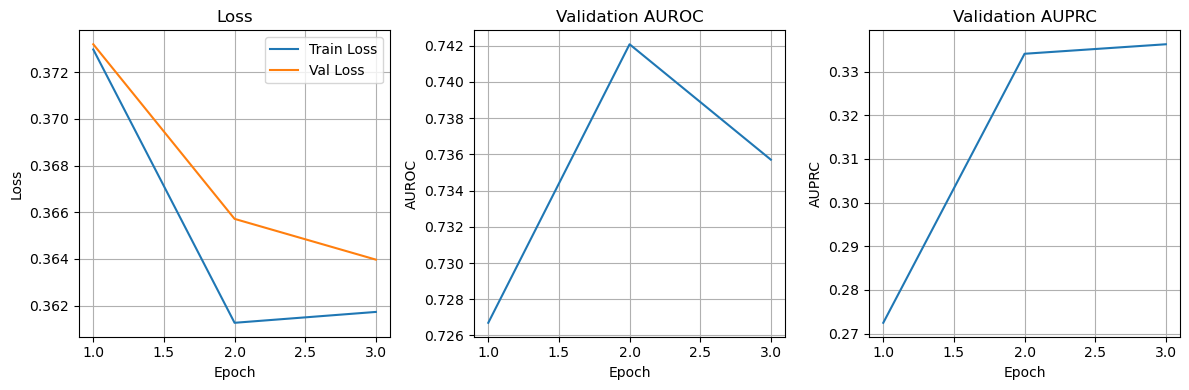

{'train_loss': [0.37296814930438993, 0.36126615190505984, 0.36173137366771696],
 'val_loss': [0.37319198870658876, 0.36571541225910187, 0.3639708836078644],
 'val_auroc': [np.float64(0.7266989539216652),
  np.float64(0.7420818251584097),
  np.float64(0.7357064517055714)],
 'val_auprc': [np.float64(0.2724552101244814),
  np.float64(0.33407638178390653),
  np.float64(0.3362540643060843)]}

In [90]:
train_transformer(model, train_loader, val_dataloader=val_loader, epochs=3, lr=1e-3)

#  Pretraining and linear probes - Q3.1

#  Simulate label scarcity - Q3.2

#  Visualising learned representations - Q3.3
